# PID Synergy Matrices — sklearn Dataset Preparation

This notebook demonstrates how to load sklearn built-in datasets and convert them into a
standardized JSON schema for **PID (Partial Information Decomposition) synergy matrix**
computation, timing scalability assessment, MI comparison, and cross-subsample stability analysis.

**What it does:**
1. Loads sklearn datasets (iris in this demo) with feature names and target labels
2. Assigns K-Fold cross-validation splits to each sample
3. Converts each sample to a JSON example with `input` (feature→value pairs), `output` (label),
   and metadata fields (fold, feature names, task type, n_classes, row index)
4. Produces a structured JSON output ready for downstream PID analysis

**Demo data:** A curated 51-example subset of the Iris dataset (3 classes, 4 features).

In [ ]:
%%capture
%pip install -q --force-reinstall numpy==2.2.6 scikit-learn==1.7.2 matplotlib==3.10.7

In [ ]:
# Colab: restart runtime after reinstalling numpy (C extensions need reload)
import importlib, sys
try:
    import numpy as _np
    if tuple(int(x) for x in _np.__version__.split('.')[:2]) < (2, 0):
        print('Restarting runtime for numpy 2.x...')
        import os; os.kill(os.getpid(), 9)
except Exception:
    pass

In [2]:
import json
import os

import numpy as np
from sklearn.datasets import (
    load_breast_cancer,
    load_diabetes,
    load_iris,
    load_wine,
)
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Load Demo Data

Load the pre-built mini dataset from GitHub (or fall back to a local file).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-fb8249-synergy-guided-oblique-splits-using-part/main/dataset_iter1_pid_synergy_dat/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data["datasets"]:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  iris: 51 examples


## Configuration

Tunable parameters for the dataset processing pipeline.

In [5]:
# --- Config ---
N_FOLDS = 5          # Number of cross-validation folds
RANDOM_STATE = 42    # Random seed for reproducibility
DECIMAL_PLACES = 6   # Rounding precision for feature values

## Fold Assignment

Assign each sample to a cross-validation fold using scikit-learn's `KFold`.

In [6]:
def make_fold_assignments(n_samples: int, n_folds: int = N_FOLDS, random_state: int = RANDOM_STATE) -> list[int]:
    """Assign each sample to a fold using KFold."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    folds = [0] * n_samples
    for fold_idx, (_, test_idx) in enumerate(kf.split(range(n_samples))):
        for idx in test_idx:
            folds[idx] = fold_idx
    return folds

## Dataset Processing

Convert a sklearn dataset into the schema-compliant JSON format. Each sample becomes a JSON
example with feature→value input, string target output, and metadata fields.

In [7]:
def process_dataset(
    name: str,
    data: np.ndarray,
    target: np.ndarray,
    feature_names: list[str],
    target_names: list[str] | None,
    task_type: str,
    n_classes: int,
) -> dict:
    """Convert a sklearn dataset to schema-compliant format."""
    n_samples, n_features = data.shape
    folds = make_fold_assignments(n_samples)

    examples = []
    for i in range(n_samples):
        # Build input as JSON string of feature name→value pairs
        feature_dict = {}
        for j, fname in enumerate(feature_names):
            val = float(data[i, j])
            feature_dict[fname] = round(val, DECIMAL_PLACES)

        input_str = json.dumps(feature_dict)

        # Build output as string label
        if target_names is not None and task_type == "classification":
            output_str = str(target_names[int(target[i])])
        else:
            output_str = str(target[i])

        example = {
            "input": input_str,
            "output": output_str,
            "metadata_fold": folds[i],
            "metadata_feature_names": feature_names,
            "metadata_task_type": task_type,
            "metadata_n_classes": n_classes,
            "metadata_row_index": i,
            "metadata_n_features": n_features,
            "metadata_n_samples": n_samples,
        }
        examples.append(example)

    return {"dataset": name, "examples": examples}

## Load All Datasets

Load 4 sklearn datasets for PID synergy analysis: breast cancer (569×30), wine (178×13),
iris (150×4), and diabetes binarized (442×10).

In [8]:
def load_all_datasets() -> list[dict]:
    """Load 4 sklearn datasets for PID synergy analysis."""
    results = []

    # 1. Breast Cancer Wisconsin (Diagnostic) - 569 × 30, binary
    bc = load_breast_cancer()
    results.append(process_dataset(
        name="breast_cancer",
        data=bc.data,
        target=bc.target,
        feature_names=list(bc.feature_names),
        target_names=["malignant", "benign"],
        task_type="classification",
        n_classes=2,
    ))
    print(f"  breast_cancer: {len(results[-1]['examples'])} examples")

    # 2. Wine - 178 × 13, 3-class
    wine = load_wine()
    results.append(process_dataset(
        name="wine",
        data=wine.data,
        target=wine.target,
        feature_names=list(wine.feature_names),
        target_names=["class_0", "class_1", "class_2"],
        task_type="classification",
        n_classes=3,
    ))
    print(f"  wine: {len(results[-1]['examples'])} examples")

    # 3. Iris - 150 × 4, 3-class
    iris = load_iris()
    results.append(process_dataset(
        name="iris",
        data=iris.data,
        target=iris.target,
        feature_names=list(iris.feature_names),
        target_names=["setosa", "versicolor", "virginica"],
        task_type="classification",
        n_classes=3,
    ))
    print(f"  iris: {len(results[-1]['examples'])} examples")

    # 4. Diabetes (binarized at median) - 442 × 10, binary
    diab = load_diabetes()
    median_target = np.median(diab.target)
    binarized_target = (diab.target > median_target).astype(int)
    results.append(process_dataset(
        name="diabetes_binarized",
        data=diab.data,
        target=binarized_target,
        feature_names=list(diab.feature_names),
        target_names=["below_median", "above_median"],
        task_type="classification",
        n_classes=2,
    ))
    print(f"  diabetes_binarized: {len(results[-1]['examples'])} examples")

    return results


print("Loading 4 sklearn datasets for PID synergy analysis...")
datasets = load_all_datasets()

output = {"datasets": datasets}
total_examples = sum(len(d["examples"]) for d in datasets)
print(f"\nTotal: {len(datasets)} datasets, {total_examples} examples")

Loading 4 sklearn datasets for PID synergy analysis...
  breast_cancer: 569 examples
  wine: 178 examples
  iris: 150 examples
  diabetes_binarized: 442 examples

Total: 4 datasets, 1339 examples


## Compare with Demo Data

Verify the generated output matches the structure of the pre-built demo data, then display
a summary comparing both.

In [9]:
# Compare structure: generated vs demo data
print("=" * 60)
print("GENERATED vs DEMO DATA COMPARISON")
print("=" * 60)

print(f"\n{'Source':<20} {'Datasets':<12} {'Total Examples':<16}")
print("-" * 48)
print(f"{'Generated':<20} {len(output['datasets']):<12} {total_examples:<16}")
demo_total = sum(len(d['examples']) for d in data['datasets'])
print(f"{'Demo (mini)':<20} {len(data['datasets']):<12} {demo_total:<16}")

# Show per-dataset breakdown for generated data
print(f"\n{'Dataset':<22} {'Samples':<10} {'Features':<10} {'Classes':<10} {'Task':<16}")
print("-" * 68)
for ds in output["datasets"]:
    ex0 = ds["examples"][0]
    print(f"{ds['dataset']:<22} {len(ds['examples']):<10} {ex0['metadata_n_features']:<10} "
          f"{ex0['metadata_n_classes']:<10} {ex0['metadata_task_type']:<16}")

# Show a sample example from the demo data
print("\n--- Sample Example (demo data, first entry) ---")
sample = data["datasets"][0]["examples"][0]
print(f"  Dataset:  {data['datasets'][0]['dataset']}")
print(f"  Output:   {sample['output']}")
print(f"  Fold:     {sample['metadata_fold']}")
print(f"  Features: {sample['metadata_n_features']}")
parsed_input = json.loads(sample["input"])
print(f"  Input preview (first 3 features):")
for k, v in list(parsed_input.items())[:3]:
    print(f"    {k}: {v}")

GENERATED vs DEMO DATA COMPARISON

Source               Datasets     Total Examples  
------------------------------------------------
Generated            4            1339            
Demo (mini)          1            51              

Dataset                Samples    Features   Classes    Task            
--------------------------------------------------------------------
breast_cancer          569        30         2          classification  
wine                   178        13         3          classification  
iris                   150        4          3          classification  
diabetes_binarized     442        10         2          classification  

--- Sample Example (demo data, first entry) ---
  Dataset:  iris
  Output:   setosa
  Fold:     1
  Features: 4
  Input preview (first 3 features):
    sepal length (cm): 5.1
    sepal width (cm): 3.5
    petal length (cm): 1.4


## Visualization

Visual overview of the datasets: sample counts, feature dimensionality, class distributions,
and fold assignments.

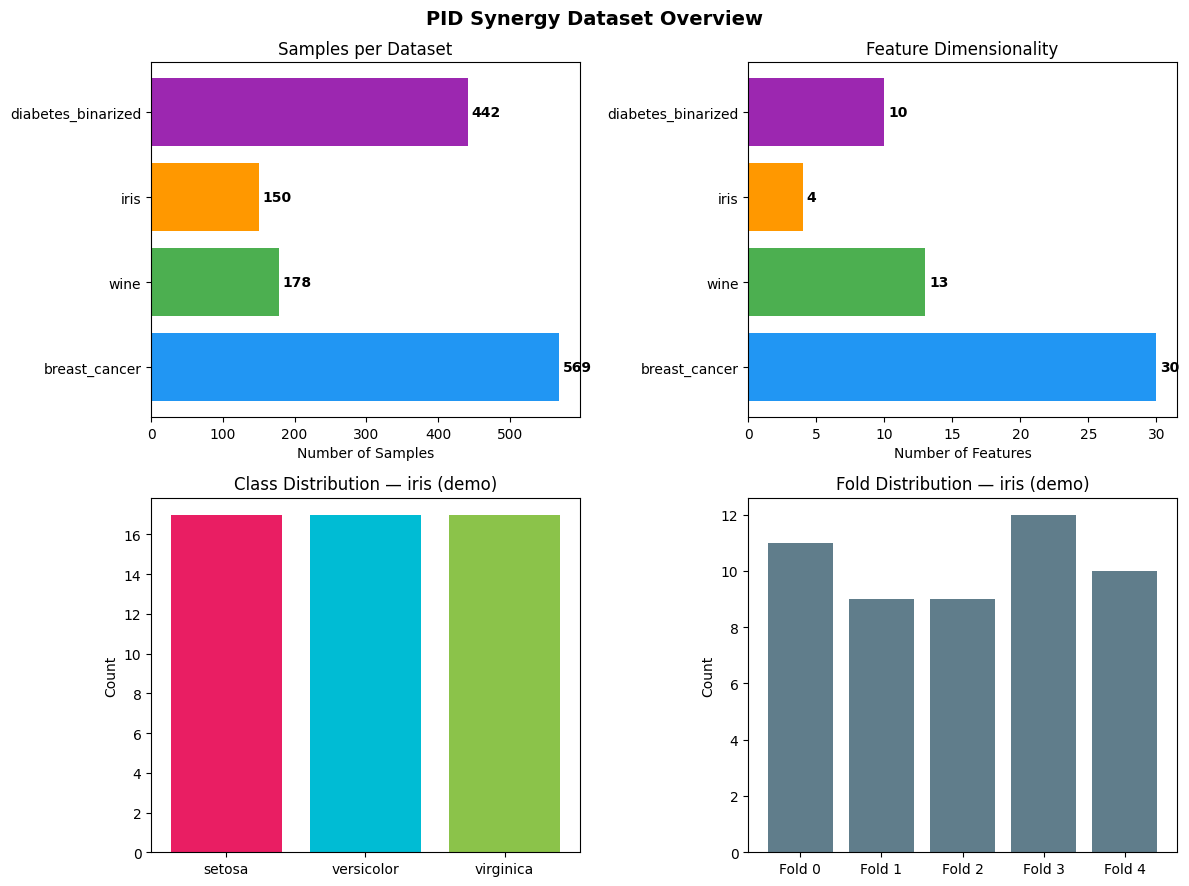

Done! All datasets processed successfully.


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle("PID Synergy Dataset Overview", fontsize=14, fontweight="bold")

# 1. Sample count per dataset
ax = axes[0, 0]
ds_names = [d["dataset"] for d in output["datasets"]]
ds_counts = [len(d["examples"]) for d in output["datasets"]]
colors = ["#2196F3", "#4CAF50", "#FF9800", "#9C27B0"]
ax.barh(ds_names, ds_counts, color=colors)
ax.set_xlabel("Number of Samples")
ax.set_title("Samples per Dataset")
for i, v in enumerate(ds_counts):
    ax.text(v + 5, i, str(v), va="center", fontweight="bold")

# 2. Feature dimensionality
ax = axes[0, 1]
ds_features = [output["datasets"][i]["examples"][0]["metadata_n_features"] for i in range(len(output["datasets"]))]
ax.barh(ds_names, ds_features, color=colors)
ax.set_xlabel("Number of Features")
ax.set_title("Feature Dimensionality")
for i, v in enumerate(ds_features):
    ax.text(v + 0.3, i, str(v), va="center", fontweight="bold")

# 3. Class distribution for iris (from demo data)
ax = axes[1, 0]
iris_examples = data["datasets"][0]["examples"]
class_counts = {}
for ex in iris_examples:
    label = ex["output"]
    class_counts[label] = class_counts.get(label, 0) + 1
ax.bar(class_counts.keys(), class_counts.values(), color=["#E91E63", "#00BCD4", "#8BC34A"])
ax.set_ylabel("Count")
ax.set_title(f"Class Distribution — {data['datasets'][0]['dataset']} (demo)")

# 4. Fold assignment distribution for iris (demo data)
ax = axes[1, 1]
fold_counts = {}
for ex in iris_examples:
    fold = ex["metadata_fold"]
    fold_counts[fold] = fold_counts.get(fold, 0) + 1
folds_sorted = sorted(fold_counts.keys())
ax.bar([f"Fold {f}" for f in folds_sorted],
       [fold_counts[f] for f in folds_sorted],
       color="#607D8B")
ax.set_ylabel("Count")
ax.set_title(f"Fold Distribution — {data['datasets'][0]['dataset']} (demo)")

plt.tight_layout()
plt.show()

print("Done! All datasets processed successfully.")